# Stop Hotspot Detection

<img align="right" src="https://anitagraser.github.io/movingpandas/assets/img/movingpandas.png">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/anitagraser/movingpandas-examples/main?filepath=3-tech-demos/stop-hotspots.ipynb)

This demo shows how to detect significant hotspots of urban activity. It combines MovingPandas, OSMnx, and Spaghetti and was inspired by:

* [Network-constrained spatial autocorrelation by James D. Gaboardi](https://github.com/pysal/spaghetti/blob/8dfec40812a9824e575822a1587b47f26fc45313/notebooks/network-spatial-autocorrelation.ipynb)
* [Simplify network topology and consolidate intersections by Geoff Boeing](https://github.com/gboeing/osmnx-examples/blob/64e104f8e3e719c23c640172c2f18ba7b46a020d/notebooks/04-simplify-graph-consolidate-nodes.ipynb)

In [9]:
import networkx as nx
import osmnx as ox
from osmnx import utils_graph
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
from datetime import timedelta
import spaghetti
import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran, plot_local_autocorrelation

ox.config(use_cache=True, log_console=True)

import warnings
warnings.simplefilter("ignore")

/var/folders/jn/wyd_ymm921bfqm95xtkbdlch0000gn/T/ipykernel_2271/3441309482.py:12: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


In [12]:
!ls

PositionsUnit-LongLat.xlsx data
Untitled.ipynb             stop-hotspots.ipynb


## Finding stops in movement trajectories

This also serves as a stress test for MovingPandas. The sample dataset contains 190k points. 

In [34]:
tracks_gdf = gpd.read_file('data/geolife_sample.gpkg')

In [44]:
    tracks_gdf.head(470)

,id,sequence,trajectory,tracker,t,geometry
0,1.0,1.0,1.0,19,2008/12/11 04:42:14.000,POINT (116.39131 39.89857)
1,2.0,2.0,1.0,19,2008/12/11 04:42:16.000,POINT (116.39132 39.89862)
2,3.0,3.0,1.0,19,2008/12/11 04:43:26.000,POINT (116.39093 39.89861)
3,4.0,4.0,1.0,19,2008/12/11 04:43:32.000,POINT (116.39083 39.89863)
4,5.0,5.0,1.0,19,2008/12/11 04:43:47.000,POINT (116.38941 39.89872)
...,...,...,...,...,...,...
465,466.0,466.0,1.0,19,2008/12/11 05:15:46.000,POINT (116.38622 39.86523)
466,2538.0,86.0,3.0,2,2009/02/04 10:06:14.000,POINT (116.38579 39.89927)
467,2539.0,87.0,3.0,2,2009/02/04 10:06:19.000,POINT (116.38584 39.89927)
468,2540.0,88.0,3.0,2,2009/02/04 10:06:24.000,POINT (116.38583 39.89923)


In [49]:
tracks_gdf["t"]

str

In [15]:
tracks_gdf['t'] = pd.to_datetime(tracks_gdf['t'])
tracks_gdf = tracks_gdf.set_index('t').tz_localize(None)
traj_collection = mpd.TrajectoryCollection(tracks_gdf, 'trajectory')

In [16]:
%%time
stop_pts = mpd.TrajectoryStopDetector(traj_collection)\
   .get_stop_points(min_duration=timedelta(seconds=180), max_diameter=100)

CPU times: user 1min 24s, sys: 202 ms, total: 1min 24s
Wall time: 1min 25s


In [17]:
len(stop_pts)

865

In [18]:
minx, miny, maxx, maxy = stop_pts.geometry.total_bounds

## Preparing the network data

In [19]:
buffer = 0.005
G = ox.graph_from_bbox(maxy+buffer, miny-buffer, minx-buffer, maxx+buffer, network_type='all')

In [20]:
len(G)

4108

In [21]:
G_proj = ox.project_graph(G)  # projects to suitable UTM CRS
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
G2 = ox.project_graph(G2, to_crs='EPSG:4326')
len(G2)

1779

In [22]:
graph_gdf = gpd.GeoDataFrame(utils_graph.graph_to_gdfs(G2, nodes=False)["geometry"])

<Axes: >

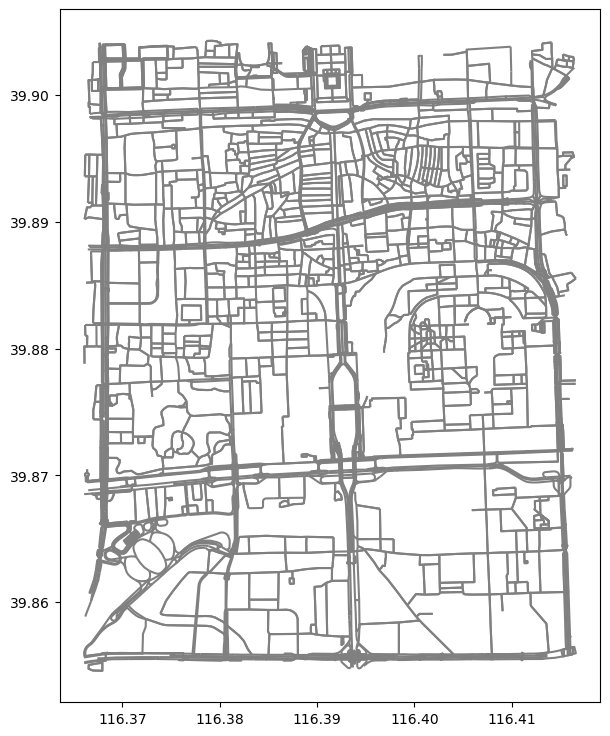

In [23]:
graph_gdf.plot(figsize=(9,9), color='grey')

It's worth noting that there's an area in the east (in the Temple of Heaven park) with a lot of stops but no network coverage. This happend because these areas are modelled as open spaces (highway=pedestrian, area=true) in OSM (https://www.openstreetmap.org/way/29182811).

<Axes: >

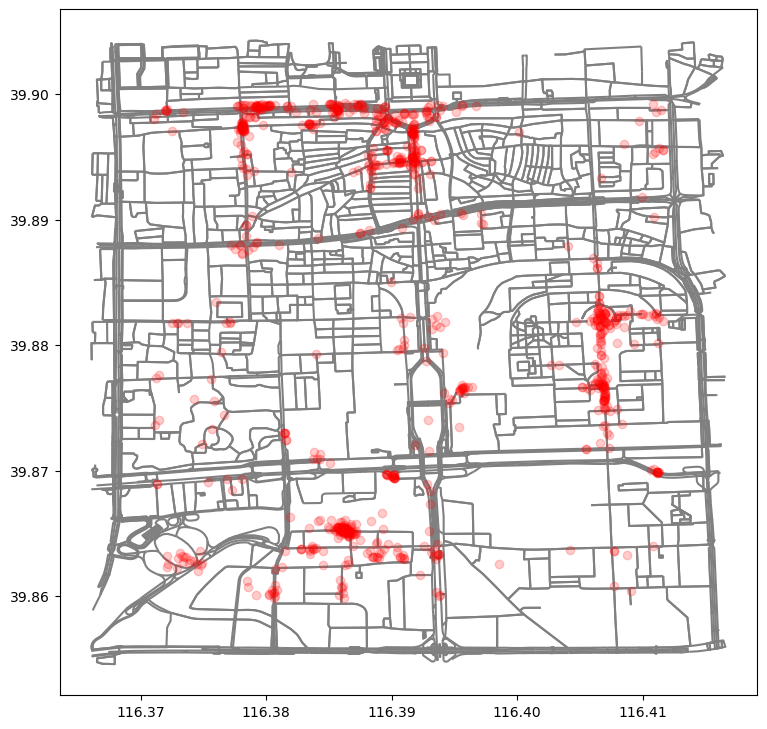

In [24]:
ax = graph_gdf.plot(figsize=(9,9), color='grey', zorder=0)
stop_pts.plot(ax=ax, color='red', zorder=3, alpha=0.2)

## Assigning stops to network edges 

In [ ]:
ntw = spaghetti.Network(in_data=graph_gdf)

In [ ]:
pp_name = "stops"  # point pattern name
ntw.snapobservations(stop_pts, pp_name, attribute=True)

## Calculating local statistics

In [ ]:
def calc_moran(net, pp_name, w):
    """Calculate a Moran's I statistic based on network arcs."""
    # Compute the counts
    pointpat = net.pointpatterns[pp_name]
    counts = net.count_per_link(pointpat.obs_to_arc, graph=False)
    # Build the y vector
    arcs = w.neighbors.keys()
    y = [counts[a] if a in counts.keys() else 0. for i, a in enumerate(arcs)]
    # Moran's I
    moran = esda.moran.Moran(y, w, permutations=99)
    return moran, y

In [ ]:
moran_ntwwn, yaxis_ntwwn = calc_moran(ntw, pp_name, ntw.w_network)

In [ ]:
_, arc_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
arc_df['n'] = yaxis_ntwwn

In [ ]:
ax = arc_df.plot(column='n', figsize=(12,9), cmap='Reds', legend=True, zorder=3, lw=3, vmax=10)
stop_pts.plot(ax=ax, color='black', alpha=0.2, zorder=0)

In [ ]:
moran_loc_ntwwn = esda.moran.Moran_Local(yaxis_ntwwn, ntw.w_network)

In [ ]:
f, ax = lisa_cluster(moran_loc_ntwwn, arc_df, p=0.05, figsize=(9,9), lw=3, zorder=3)
stop_pts.plot(ax=ax, zorder=1, alpha=.2, color="black", markersize=30)

## Continue exploring MovingPandas


1. [Bird migration analysis](1-bird-migration.ipynb)
1. [Ship data analysis](2-ship-data.ipynb)
1. [Horse collar data exploration](3-horse-collar.ipynb)
1. [Stop hotspot detection](4-stop-hotspots.ipynb)
1. [OSM traces](5-osm-traces.ipynb)